In [151]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")
from adjustText import adjust_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import RELACS as rel
import pymc3 as pm
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Identify dynamic chromatin accessible regions due to EPZ treatment

In [2]:
%%bash

### CREATE MERGED PEAK SET

cat /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/MACS2/*.narrowPeak | bedtools sort | bedtools merge | grep -v "^MT\|^J\|^G" > ../INTERMEDIATE_FILES/mergedPeaks_mESC_ATAC_EPZvsDMSO.bed

In [59]:
%%bash 

### COUNT UNIQUELY MAPPING READS ON CONSENSUS ATAC REGIONS ###

multiBamSummary BED-file -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/*.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_DMSO-EPZ.mat.gz \
--BED ../INTERMEDIATE_FILES/mergedPeaks_mESC_ATAC_EPZvsDMSO.bed \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
-p 20 \
--outRawCounts ../INTERMEDIATE_FILES/mESC_ATAC_DMSO-EPZ.counts \
-e \
--minMappingQuality 3 

Number of bins found: 31696


In [60]:
! head ../INTERMEDIATE_FILES/mESC_ATAC_DMSO-EPZ.counts

#'chr'	'start'	'end'	'mESC_ATAC_DMSO_rep1.short.cleaned.bam'	'mESC_ATAC_DMSO_rep2.short.cleaned.bam'	'mESC_ATAC_DMSO_rep3.short.cleaned.bam'	'mESC_ATAC_EPZ_rep1.short.cleaned.bam'	'mESC_ATAC_EPZ_rep2.short.cleaned.bam'	'mESC_ATAC_EPZ_rep3.short.cleaned.bam'
6	98609215	98609309	11.0	15.0	11.0	32.0	27.0	8.0
6	98666689	98666794	14.0	10.0	14.0	23.0	31.0	24.0
2	179176980	179177071	14.0	12.0	20.0	16.0	20.0	20.0
2	179193887	179194049	44.0	26.0	48.0	46.0	32.0	34.0
19	30018202	30018280	16.0	14.0	18.0	26.0	10.0	18.0
19	30030346	30030573	45.0	56.0	82.0	80.0	61.0	57.0
1	137738203	137738440	38.0	56.0	46.0	57.0	40.0	50.0
4	94941311	94941492	62.0	66.0	64.0	62.0	74.0	74.0
4	94978960	94979227	90.0	92.0	104.0	105.0	104.0	102.0


In [61]:
### IMPORT COUNTS ###

peak = pd.read_csv("../INTERMEDIATE_FILES/mESC_ATAC_DMSO-EPZ.counts",sep="\t")
peak.columns = ["chr","start","end","DMSO1","DMSO2","DMSO3","EPZ1","EPZ2","EPZ3"]
peak = peak.loc[peak.chr != "MT"]

peak.sample(1000)[["chr","start","end"]].to_csv("../INTERMEDIATE_FILES/Random_ATAC_peaks_1000_mESC.bed",sep="\t",header=None,index=None)

peak["ID"] = ['_'.join([str(peak.chr.loc[i]), str(peak.start.loc[i]),str(peak.end.loc[i])]) for i in peak.index]
peak = peak[list(peak)[3:]]
peak.drop_duplicates("ID",inplace=True)
# peak.drop(["EPZ2"], inplace=True, axis=1)
print(peak.shape)
peak.head()

(31696, 7)


,DMSO1,DMSO2,DMSO3,EPZ1,EPZ2,EPZ3,ID
0,11.0,15.0,11.0,32.0,27.0,8.0,6_98609215_98609309
1,14.0,10.0,14.0,23.0,31.0,24.0,6_98666689_98666794
2,14.0,12.0,20.0,16.0,20.0,20.0,2_179176980_179177071
3,44.0,26.0,48.0,46.0,32.0,34.0,2_179193887_179194049
4,16.0,14.0,18.0,26.0,10.0,18.0,19_30018202_30018280


/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  warnings.warn(x, RRuntimeWarning)


                      DMSO1 DMSO2 DMSO3 EPZ1 EPZ2 EPZ3
6_98609215_98609309      11    15    11   32   27    8
6_98666689_98666794      14    10    14   23   31   24
2_179176980_179177071    14    12    20   16   20   20
2_179193887_179194049    44    26    48   46   32   34
19_30018202_30018280     16    14    18   26   10   18
19_30030346_30030573     45    56    82   80   61   57
    DMSO1     DMSO2     DMSO3      EPZ1      EPZ2      EPZ3 
0.8861410 0.9637516 1.0159460 1.1306399 1.0788008 1.0022232 


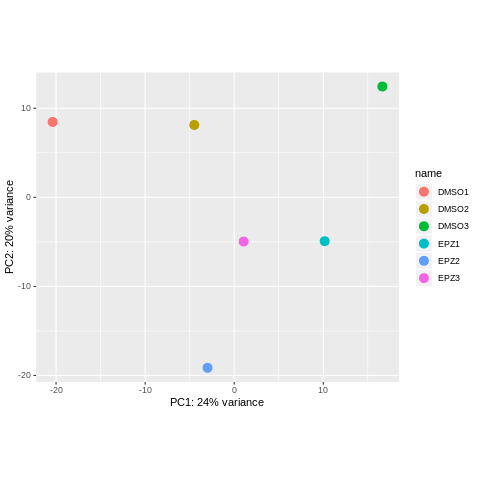

In [62]:
%%R -i peak

### PERFORM DIFFERENTIAL ATAC ANALYSIS ###

library("DESeq2")
library("ggplot2")

rownames(peak) = peak$ID

peak = peak[,c(1,2,3,4,5,6)]

print(head(peak))

# CREATE DESIGN TABLE
design_table=data.frame(row.names = colnames(peak),
                        condition = c(rep("DMSO",3),rep("EPZ",3)))


all(rownames(design_table) == colnames(count))

# CREATE DESEQ2 OBJECT
dds = DESeqDataSetFromMatrix(countData = peak,
                              colData = design_table,
                              design = ~ condition)

dds <- estimateSizeFactors(dds)
print(dds@colData$sizeFactor)

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]


rld = rlog(dds, blind=TRUE)

A=plotPCA(rld, ntop=dim(assay(rld))[1], returnData=T, intgroup=c("condition"))
percentVar <- round(100 * attr(A, "percentVar"))
pca_plt=ggplot(A, aes(x=PC1, y=PC2, col=name))+
  geom_point(size=4)+
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()


matrix_rlog=as.data.frame(t(assay(rld)))
write.table(matrix_rlog,"../INTERMEDIATE_FILES/matrix_rlog-all_atac_mESC.tsv",sep="\t",quote=F)

pca_plt

             PC1        PC2        PC3        PC4        PC5           PC6
DMSO1  20.382902  -8.463653 -10.927079  -0.667546   5.592252  8.543396e-14
DMSO2   4.480231  -8.124647  21.635734  -2.147707  -2.792204  8.543396e-14
DMSO3 -16.632736 -12.441850  -8.538205  -8.590474  -5.798592  8.543396e-14
EPZ1  -10.159576   4.925290   1.656518   5.961619  19.469327  8.543396e-14
EPZ2    2.992554  19.143200  -0.853369 -13.140686  -4.348587  8.543396e-14


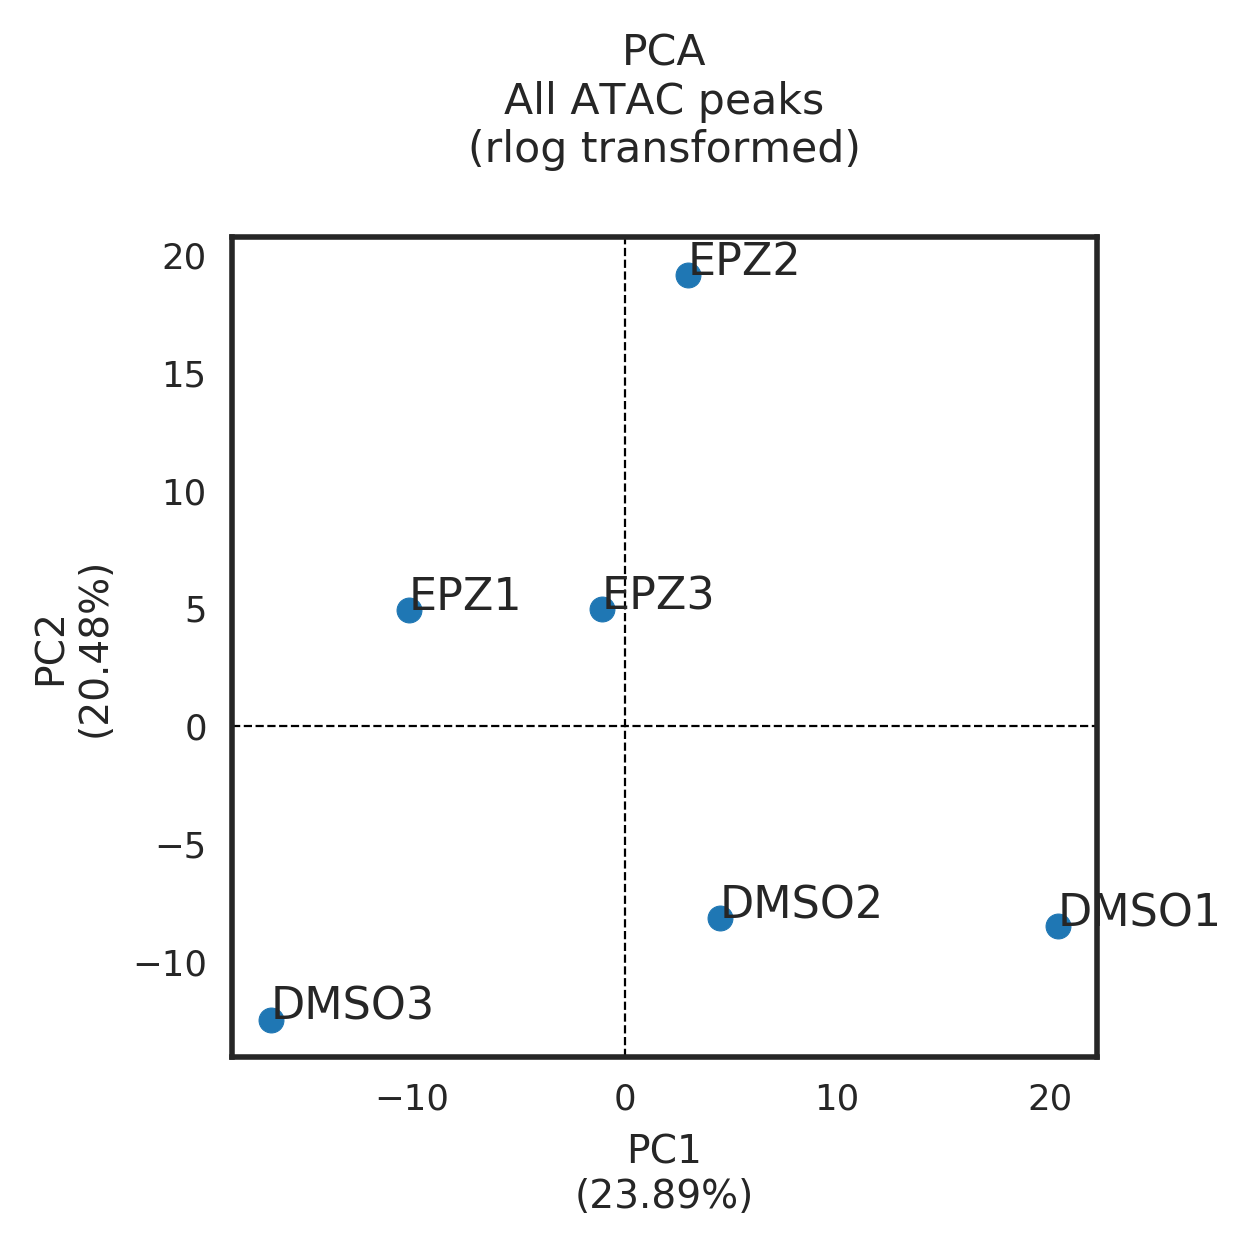

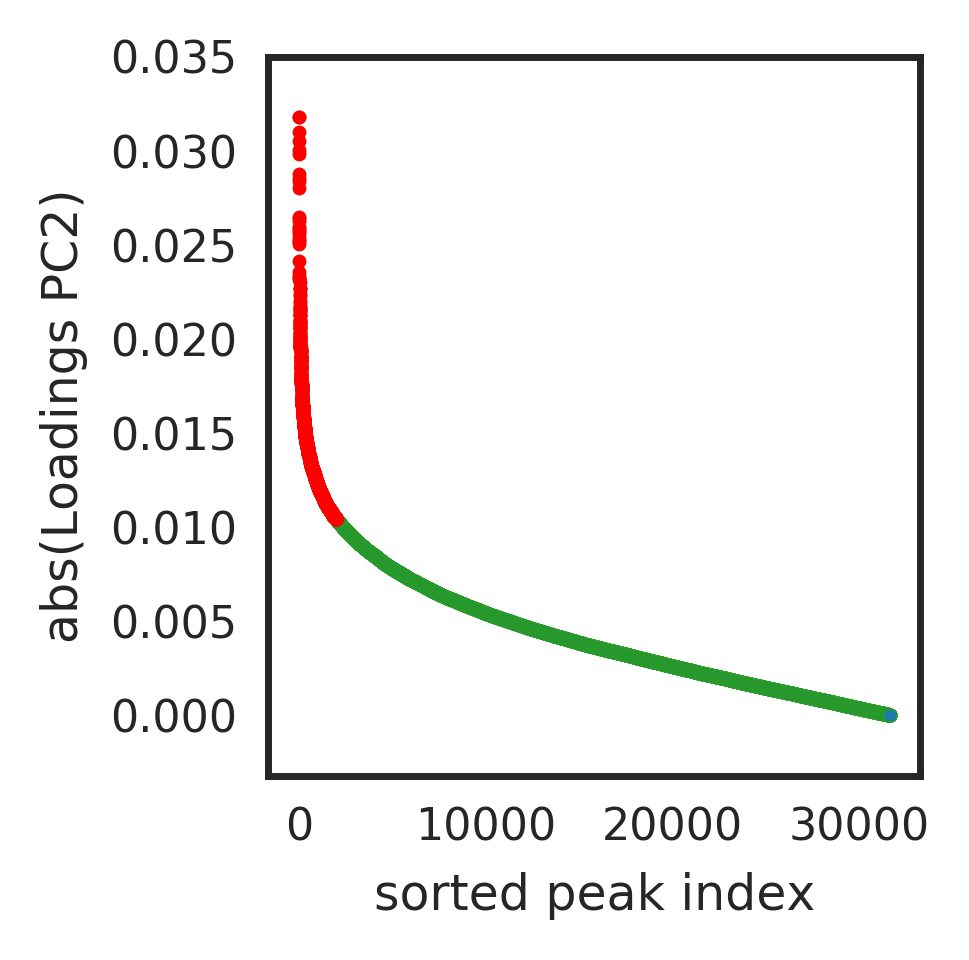

In [63]:
### HERE WE PERFORM PCA USING SKLEARN ### 

rlog = pd.read_csv("../INTERMEDIATE_FILES/matrix_rlog-all_atac_mESC.tsv",sep="\t")
rlog.head()

pca = PCA()
pca_data = pca.fit_transform(rlog)

per_variance = [round(i,2)*100 for i in pca.explained_variance_ratio_]
labels = ["PC{}".format(i) for i in range(len(per_variance)+1)[1:]]

# HERE WE PLOT THE ACTUAL PCA PLOT ###

# first, let's put the data into a nice dataframe format
pca_df = pd.DataFrame(pca_data, index = ["DMSO1","DMSO2","DMSO3","EPZ1","EPZ2","EPZ3"], columns=labels)
print(pca_df.head())

plt.figure(dpi=320, figsize=(4,4))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("PCA\nAll ATAC peaks\n(rlog transformed)\n")
plt.xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
plt.ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

# plt.ylim((-20,20))
# plt.xlim((-12,17))
plt.axhline(0,linestyle="--",linewidth=0.5, color="k")
plt.axvline(0,linestyle="--",linewidth=0.5, color="k")
plt.tight_layout()

plt.savefig("../FIGURES/PCA_ATACPeaks_mESC.png")



### HERE WE SORT THE ABSOLUTE VALUE OF THE PC1 LOADINGS IN DECREASING ORDER ###

genes = rlog.columns
    
loading_scores_PC2 = pd.Series(pca.components_[1], index = genes)
sorted_loadings_PC2 = loading_scores_PC2.abs().sort_values(ascending=False)

All_genes_PC2 = sorted_loadings_PC2.index.values
top_500_genes_PC2 = sorted_loadings_PC2[:2000].index.values
# print("TOP 10 PC1 GENES:\n",loading_scores_PC1[top_500_genes_PC1],'\n')

# loading_scores_PC2 = pd.Series(pca.components_[1], index = genes)
# sorted_loadings_PC2 = loading_scores_PC2.abs().sort_values(ascending=False)

# top_10_genes_PC2 = sorted_loadings_PC2[:500].index.values
# print("TOP 10 PC2 GENES:\n",loading_scores_PC2[top_10_genes_PC2])

plt.figure(dpi=400,figsize=(2.5,2.5))
plt.scatter(range(len(loading_scores_PC2[All_genes_PC2].values)), np.fabs(loading_scores_PC2[All_genes_PC2]), s=5,edgecolor='C2',facecolor=None,alpha=0.4)
plt.scatter(range(len(loading_scores_PC2[top_500_genes_PC2].values)), np.fabs(loading_scores_PC2[top_500_genes_PC2]), s=5,color='r',zorder=1)
plt.ylabel("abs(Loadings PC2)")
plt.xlabel("sorted peak index")
plt.tight_layout()
plt.savefig("../FIGURES/sorted_loadings_PC2_ATACPeaks_mESC.png")

In [64]:
### WE WRITE THE ATAC REGIONS WITH HIGHEST PC2 LOADINGS TO FILE (TOP 2000) ###

loading_scores_PC2 = pd.Series(pca.components_[1], index = genes)
sorted_loadings_PC2 = loading_scores_PC2.abs().sort_values(ascending=False)

top_1000_genes_PC2 = sorted_loadings_PC2[:2000].index.values
t1000_PC2 = loading_scores_PC2[top_1000_genes_PC2]

with open("../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv",'w') as out:
    for i in range(2000):
        idx =t1000_PC2.index[i]
        #print(idx, t500_PC2.loc[idx])
        bed = idx.split("_")
        bed = bed + ["topPeak_{}".format(i+1),str(t1000_PC2.loc[idx])+"\n"]
        out.write("\t".join(bed))




In [103]:
%%bash

### SEPARATE PEAKS WITH POSITIVE AND NEGATIVE LOADINGS IN TWO DIFFERENT FILES

awk -v OFS="\t" '{if($5>0){print $0,"atacUp_mESC"}}' ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_mESC.bed
awk -v OFS="\t" '{if($5<0){print $0,"atacDown_mESC"}}' ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_mESC.bed
awk -v OFS="\t" '{print $1,$2,$3,"atacRand_mESC"}' ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000_mESC.bed > ../INTERMEDIATE_FILES/ATAC_Random_ATAC_peaks_1000_mESC.bed




In [66]:
! head ../INTERMEDIATE_FILES/ATAC_Random_ATAC_peaks_1000_mESC.bed

13	55963415	55963487	atacRand
3	88382106	88382190	atacRand
13	103109989	103110160	atacRand
18	78586616	78586695	atacRand
2	32928369	32928464	atacRand
3	132984250	132984385	atacRand
2	119809054	119809141	atacRand
3	152100446	152100670	atacRand
6	75288724	75288975	atacRand
3	131237902	131238024	atacRand


In [67]:
%%bash

### ATAC-PEAKS ANNOTATION ### 

source activate Homer

annotatePeaks.pl ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv mm10 \
-gtf /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf \
> ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.annotated


	Peak file = ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv
	Genome = mm10
	Organism = mouse
	Custom annotation GTF file: /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf (using transcript_id)
	Peak/BED file conversion summary:
		BED/Header formatted lines: 2000
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 2000
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Processing custom annotation file...
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Prioritizing Annotation

In [68]:
PEAK_rle = peak.copy()
PEAK_rle.index = PEAK_rle["ID"]
PEAK_rle.drop(["ID"],inplace=True, axis=1)

1/rel.RLE(PEAK_rle)[0]

DMSO1    1.128489
DMSO2    1.037612
DMSO3    0.984304
EPZ1     0.884455
EPZ2     0.926955
EPZ3     0.997782
dtype: float64

In [52]:
%%bash 

### WITH DEEPTOOLS ###

module load deeptools

bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep1.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_DMSO_rep1.filtered.PeakScaled.bw --scaleFactor 1.128489 -p 20 -e 

bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep2.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_DMSO_rep2.filtered.PeakScaled.bw --scaleFactor 1.037612 -p 20 -e 

bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep3.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_DMSO_rep3.filtered.PeakScaled.bw --scaleFactor 0.984304 -p 20 -e 


bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_EPZ_rep1.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_EPZ_rep1.filtered.PeakScaled.bw --scaleFactor 0.884455 -p 20 -e 

bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_EPZ_rep2.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_EPZ_rep2.filtered.PeakScaled.bw --scaleFactor 0.926955 -p 20 -e 

bamCoverage -b /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_EPZ_rep3.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_EPZ_rep3.filtered.PeakScaled.bw --scaleFactor 0.997782 -p 20 -e 



bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep1.short.cleaned.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: 58
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 232
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep2.short.cleaned.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genome

In [69]:
PEAK_rle = peak.copy()
PEAK_rle.index = PEAK_rle["ID"]
PEAK_rle.drop(["ID"],inplace=True, axis=1)

PEAK_rle1 = PEAK_rle[["DMSO1","EPZ1"]] 
1/rel.RLE(PEAK_rle1)[0]

DMSO1    1.130388
EPZ1     0.884652
dtype: float64

In [70]:
%%bash 

### WITH DEEPTOOLS ###

module load deeptools

bamCompare -b1 /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_EPZ_rep1.short.cleaned.bam \
-b2 /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep1.short.cleaned.bam \
-o ../INTERMEDIATE_FILES/mESC_ATAC_EPZvsDMSO_rep1.short.cleaned.bw --scaleFactors 0.884652:1.130388 -p 20 -e

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_EPZ_rep1.short.cleaned.bam', '/data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC_ATAC_DMSOvsEPZ_Revisions/output_snakePipes_trimgalore/short_bams/mESC_ATAC_DMSO_rep1.short.cleaned.bam']
binLength: 50
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: 59
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 236


In [71]:
%%bash 

### WITH DEEPTOOLS ###

module load deeptools

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_mESC.bed ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_mESC.bed ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000_mESC.bed \
-S ../INTERMEDIATE_FILES/*filtered.PeakScaled.bw \
-o ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks_mESC.mat.gz --referencePoint center -b 500 -a 500 -bs 5 --outFileNameMatrix ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks_mESC.txt \
--missingDataAsZero -p 20 

In [72]:
%%bash

### WITH DEEPSTATS ###

source activate deepStats

dsCompareCurves -i ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks_mESC.txt -o ../INTERMEDIATE_FILES/DEEPSTATS_atac_on_dynamic_mESC \
-c score --regionLabels 'ATAC Up;ATAC Down; ATAC Random' --scoreLabels 'DMSO1;DMSO2;DMSO3;EPZ1;EPZ2;EPZ3' \
--signalName ATAC-seq --firstRegionName 'PEAK CENTER'

2020-05-12 13:01:19 Extracting metadata from file:
    /data/manke/group/ferrari/PhD_project/reproducible_code_paper/code_paper/figure_6/INTERMEDIATE_FILES/ATAC_on_DynamicPeaks_mESC.txt ... Done!
2020-05-12 13:01:19 --comparison is set: comparing scores.
2020-05-12 13:01:20 Boostraps starting with 4 cores, for each group:
   Number of bootstraps to perform = 1000 
   Number of bins to analyze = 200 
2020-05-12 13:01:21 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used: ATAC Up 
   Number of regions to analyze: 1176... Done!
2020-05-12 13:01:26 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used: ATAC Down 
   Number of regions to analyze: 824... Done!
2020-05-12 13:01:29 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used:  ATAC Random 
   Number of regions to analyze: 1000... Done!
2020-05-12 13:01:34 Starting to boostrap values for th

In [104]:
! head ../INTERMEDIATE_FILES/ATAC_Random_ATAC_peaks_1000_mESC.bed

13	55963415	55963487	atacRand_mESC
3	88382106	88382190	atacRand_mESC
13	103109989	103110160	atacRand_mESC
18	78586616	78586695	atacRand_mESC
2	32928369	32928464	atacRand_mESC
3	132984250	132984385	atacRand_mESC
2	119809054	119809141	atacRand_mESC
3	152100446	152100670	atacRand_mESC
6	75288724	75288975	atacRand_mESC
3	131237902	131238024	atacRand_mESC


In [105]:
%%bash 

### EXTEND ATAC REGIONS TO A COMMON 1000 bp ###

awk -v OFS="\t" '{printf "%s\t%d\t%d\t%s\n", $1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250,$6}' ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_mESC.bed > ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_Ext_mESC.bed
awk -v OFS="\t" '{printf "%s\t%d\t%d\t%s\n", $1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250,$6}' ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_mESC.bed > ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_Ext_mESC.bed
awk -v OFS="\t" '{printf "%s\t%d\t%d\t%s\n", $1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250,$4}' ../INTERMEDIATE_FILES/ATAC_Random_ATAC_peaks_1000_mESC.bed > ../INTERMEDIATE_FILES/Random_ATAC_peaks_Ext_mESC.bed



In [75]:
%%bash

### RUN DIFFERENTIAL MOTIF ANALYSIS FOR DYNAMIC ATAC REGIONS ###

source activate gimme

gimme motifs -n ../INTERMEDIATE_FILES/ATAC_mESC_Up -g /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa \
../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_Ext_mESC.bed

/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [76]:
%%bash

### RUN DIFFERENTIAL MOTIF ANALYSIS FOR DYNAMIC ATAC REGIONS ###

source activate gimme

gimme motifs -n ../INTERMEDIATE_FILES/ATAC_mESC_Down -g /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa \
../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_Ext_mESC.bed

/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [106]:
%%bash

cat ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_Ext_mESC.bed ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_Ext_mESC.bed ../INTERMEDIATE_FILES/Random_ATAC_peaks_Ext_mESC.bed \
| bedtools sort | uniq -w 10 | awk -v OFS="\t" 'BEGIN {print "loc","cluster"}; {print $1":"$2"-"$3,$4}' > ../INTERMEDIATE_FILES/ATAC_topVar_PC2_Ext_maelstrom_mESC.txt

In [136]:
%%bash

### combine mESC and NPC48h for maelstrom

awk -v OFS="\t" '{printf "%s\t%d\t%d\tatacUp_NPC48h\n",$1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250}' ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC_500bpExt.txt
awk -v OFS="\t" '{printf "%s\t%d\t%d\tatacDown_NPC48h\n",$1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250}' ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC_500bpExt.txt
awk -v OFS="\t" '{printf "%s\t%d\t%d\tatacRand_NPC48h\n",$1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250}' ../INTERMEDIATE_FILES/ATAC_onBackground_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onBackground_NPC_500bpbExt.txt



cat ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC_500bpExt.txt \
../INTERMEDIATE_FILES/ATAC_onSigDown_NPC_500bpExt.txt \
../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_Ext_mESC.bed \
../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_Ext_mESC.bed \
| bedtools sort | uniq -w 10 | awk -v OFS="\t" 'BEGIN {print "loc","cluster"}{printf "%s:%d-%d\t%s\n",$1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250,$4}' > ../INTERMEDIATE_FILES/DynamicATAC_mESC_NPC48h_500bp.txt


# awk -v OFS="\t" '{printf "%s:%d-%d\t%s\n",$1,($2+(($3-$2)/2))-250,($2+(($3-$2)/2))+250,$4}' ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC_500bpExt.txt


In [107]:
! cat ../INTERMEDIATE_FILES/ATAC_topVar_PC2_Ext_maelstrom_mESC.txt

loc	cluster
1:3912446-3912946	atacDown_mESC
1:3981967-3982467	atacRand_mESC
1:6117535-6118035	atacUp_mESC
1:9748229-9748729	atacDown_mESC
1:9768652-9769152	atacUp_mESC
1:10285476-10285976	atacDown_mESC
1:10397808-10398308	atacRand_mESC
1:11277763-11278263	atacDown_mESC
1:11395332-11395832	atacDown_mESC
1:12020551-12021051	atacRand_mESC
1:12657391-12657891	atacUp_mESC
1:13496329-13496829	atacRand_mESC
1:13531429-13531929	atacRand_mESC
1:15286520-15287020	atacUp_mESC
1:15892451-15892951	atacUp_mESC
1:16093125-16093625	atacUp_mESC
1:17009599-17010099	atacRand_mESC
1:17727079-17727579	atacUp_mESC
1:18793569-18794069	atacRand_mESC
1:20786966-20787466	atacRand_mESC
1:21014412-21014912	atacRand_mESC
1:24042995-24043495	atacRand_mESC
1:24100120-24100620	atacUp_mESC
1:24683910-24684410	atacUp_mESC
1:24699278-24699778	atacRand_mESC
1:26388441-26388941	atacUp_mESC
1:26687277-26687777	atacUp_mESC
1:26687894-26688394	atacUp_mESC
1:28417832-28418332	atacDown_mESC
1:28611292-28611792	atacUp_mESC
1:30

In [81]:
!rm -r ../INTERMEDIATE_FILES/Maelstrom_ATAC_mESC

In [245]:
%%bash

### RUN DIFFERNTIAL MOTIF ANALYSIS FOR ATAC PEAKS OVERLAPPING DEG PROMOTERS ###

source activate gimme

gimme maelstrom ../INTERMEDIATE_FILES/ATAC_topVar_PC2_Ext_maelstrom_mESC.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_mESC_2



/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [248]:
! head ../INTERMEDIATE_FILES/DiffMotifs_ATAC_NPC48h.tsv

	atac_down	atac_up
GM.5.0.Sox.0001	0.0	-2.823590626294989
GM.5.0.Homeodomain.0001	0.0	0.0
GM.5.0.Mixed.0001	0.0	0.0
GM.5.0.Nuclear_receptor.0001	0.0	0.0
GM.5.0.Mixed.0002	1.1962911029191337	0.0
GM.5.0.Nuclear_receptor.0002	0.0	0.0
GM.5.0.bHLH.0001	0.0	0.0
GM.5.0.Myb_SANT.0001	0.0	0.0
GM.5.0.C2H2_ZF.0001	0.0	0.23853692926456044


In [137]:
# ! rm -r ../INTERMEDIATE_FILES/Maelstrom_ATAC_mESC_NPC48h

In [206]:
res_NPC48h

,Unnamed: 0,up,down
0,GM.5.0.Sox.0001,-3.134445,0.769616
1,GM.5.0.Homeodomain.0001,0.102165,0.000000
2,GM.5.0.Mixed.0001,0.000000,0.000000
3,GM.5.0.Nuclear_receptor.0001,0.002787,0.000000
4,GM.5.0.Mixed.0002,0.000000,0.000000
...,...,...,...
1791,GM.5.0.C2H2_ZF.0316,0.000000,0.000000
1792,GM.5.0.C2H2_ZF.0317,0.000000,0.000000
1793,GM.5.0.Ets.0049,0.000000,0.000000
1794,GM.5.0.Unknown.0208,0.000000,-0.305355


,atac_down,atac_up,atacDown,atacUp
GM.5.0.Nuclear_receptor.0003,0.000000,0.000000,0.000000,3.800440
GM.5.0.Sox.0002,1.516456,0.000000,6.801498,0.000000
GM.5.0.Sox.0003,3.167982,0.000000,0.000000,0.000000
GM.5.0.Mixed.0004,0.000000,3.713981,0.000000,0.000000
GM.5.0.C2H2_ZF.0009,0.000000,0.000000,0.000000,2.456651
...,...,...,...,...
GM.5.0.Ets.0045,0.000000,2.959206,0.000000,0.000000
GM.5.0.Unknown.0189,0.000000,2.115701,0.000000,0.000000
GM.5.0.C2H2_ZF.0309,0.000000,0.000000,-0.861182,3.023028
GM.5.0.Unknown.0204,0.000000,0.000000,0.000000,3.208047


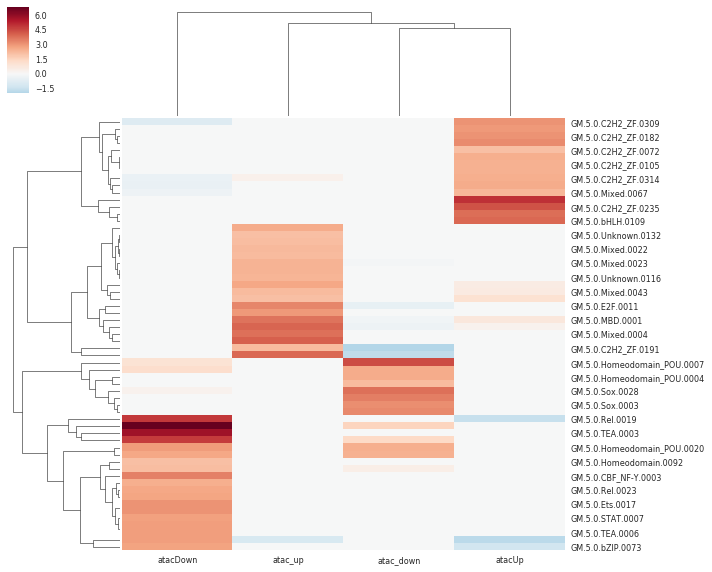

In [275]:
### create plot combining results of motif enrichment for NPC48h and mESC

res_NPC48h = pd.read_csv("../INTERMEDIATE_FILES/DiffMotifs_ATAC_NPC48h.tsv",sep="\t", index_col=0)
res_mESC = pd.read_csv("../INTERMEDIATE_FILES/Maelstrom_ATAC_mESC/final.out.csv",sep="\t", index_col=0)

comb = res_NPC48h.merge(res_mESC, how='inner',right_index=True,left_index=True)
comb

# .index = comb["Unnamed: 0_x"]
comb.drop(["atacRand"],axis=1,inplace=True)
comb
sns.clustermap(comb[["atac_up","atac_down","atacDown","atacUp"]][np.any(comb[["atac_up","atac_down","atacDown","atacUp"]] >= 2, 1)],cmap="RdBu_r",center=0)
comb[np.any(comb >= 2, 1)]


/package/anaconda3/bin/ipython:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 12000x6000 with 0 Axes>

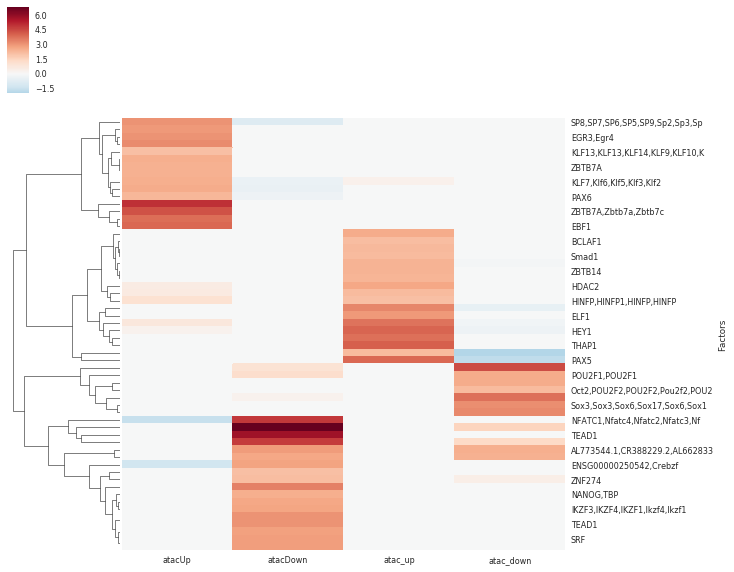

In [276]:
### TRANSLATE MOTIF IDS TO PUTATIVE TRANSCRIPTION FACTORS ###

m2f = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_1/gimme.vertebrate.v5.0.motif2factors.txt", index_col=0)
m2f_ = [",".join(m2f.groupby("Motif").get_group(j)['Factor'].values) for j in m2f.index.unique()]
m2f = pd.Series(m2f_, name="Factors", index = m2f.index.unique()).to_frame()
m2f.Factors = m2f.Factors.str.slice(0,30)

df = comb.merge(m2f, right_index=True, left_index=True).set_index("Factors")
df = df[["atacUp","atacDown","atac_up","atac_down"]]
#df[["down","up"]][np.any(abs(df[["down","up"]]) >= 2, 1)]
plt.figure(dpi=400, figsize=(30,15))
cm_ = sns.clustermap(df[np.any(df >= 2, 1)],cmap="RdBu_r",center=0, col_cluster=False)
# cm.fig.subplots_adjust(right=0.5)
plt.setp(cm_.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()

In [267]:
# cm_.data2d[43:] #--> mESC UP
# cm_.data2d[4:25] #--> mESC DOWN
# cm_.data2d[25:43] #--> NPC48h UP
# cm_.data2d[:10] #--> NPC48h DOWN



,atacUp_mESC,atacDown_mESC,atac_up,atac_down
Factors,,,,
"Sox3,Sox3,Sox6,Sox17,Sox6,Sox1",0.000000,0.000000,0.000000,3.167982
"SOX10,Sox10,SOX9,Sox9",0.000000,0.000000,0.000000,3.282696
"Oct4,TBP,TBPL2,Tbpl2,POU2F1,PO",0.000000,0.000000,0.000000,2.502928
"Oct2,POU2F2,POU2F2,Pou2f2,POU2",0.000000,0.000000,0.000000,2.135433
"POU2F1,POU2F1,POU",0.000000,2.499799,0.000000,1.616521
"AL773544.1,CR388229.2,AL662833",0.000000,3.599441,0.000000,2.431238
"POU2F1,POU2F1",0.000000,2.811562,0.000000,2.517178
POU5F1,0.000000,2.982310,0.000000,2.417315
"AL773544.1,CR388229.2,AL662833",0.000000,3.801488,0.000000,4.418548


In [235]:

cm_.data2d[:15] #--> mESC UP
cm_.data2d[40:] #--> mESC DOWN
cm_.data2d[15:33] #--> NPC48h UP
cm_.data2d[33:40] #--> NPC48h DOWN


,atacUp,atacDown,atac_up,atac_down
Factors,,,,
Smad1,0.000000,0.0,2.554919,0.000000
BCLAF1,0.000000,0.0,2.115701,0.000000
"E2F1,EP300",0.000000,0.0,2.215815,0.000000
Smad1,0.000000,0.0,2.176151,0.000000
"E2F4,ELF1",0.000000,0.0,2.385478,-0.140245
ZBTB14,0.000000,0.0,2.362063,-0.006381
BCLAF1,0.000000,0.0,2.301877,0.000000
HDAC2,0.591017,0.0,2.608758,0.000000
"HINFP1,HINFP",0.634514,0.0,2.161024,0.000000


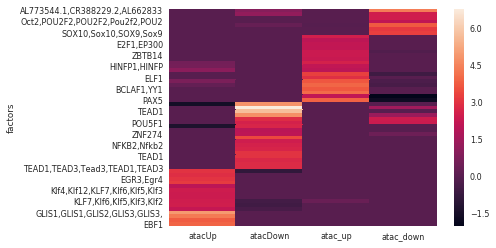

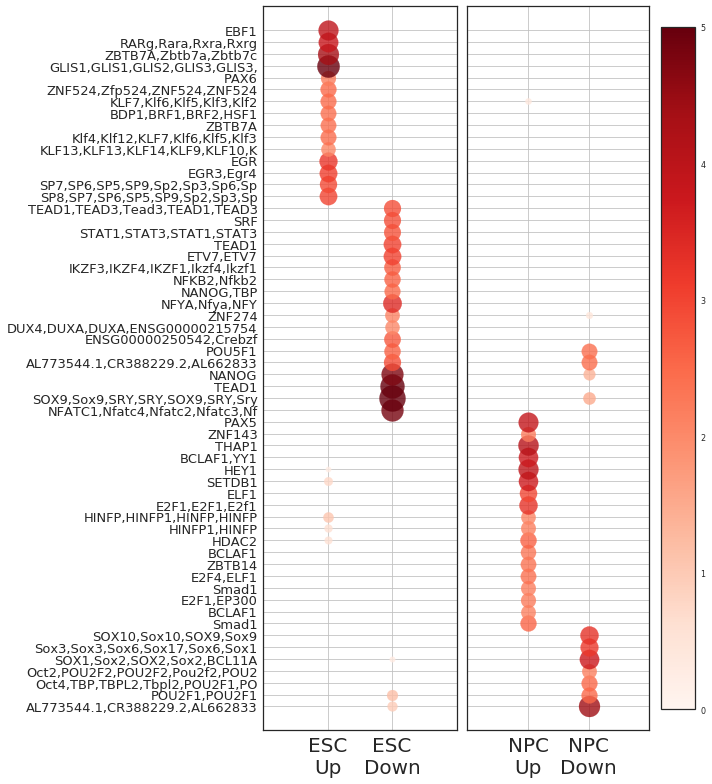

In [281]:
### PLOT RESULTS AND SAVE ###

data = cm_.data2d[np.any(cm_.data2d >= 2, 1)]
data["factors"] = data.index
data.index = range(data.shape[0])
data = data.reindex(labels = list(data.index[33:40]) + list(data.index[15:33]) + list(data.index[40:]) + list(data.index[:15]), axis=0)
data.index = data["factors"]
data.drop(["factors"],axis='columns', inplace=True)

sns.heatmap(data)

fig,ax = plt.subplots(1,2, figsize=(10,11), gridspec_kw = {'width_ratios':[1.7, 2]})
ax[0].grid(color="silver")

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(["ESC\nUp","ESC\nDown"],size=20)

ax[0].set_yticks(range(data.shape[0]))
ax[0].set_yticklabels(data.index, size=13)
ax[0].set_xlim(-1,2)
ax[0].set_ylim(-2,data.shape[0]+1)
norm = mcolors.Normalize(vmin=0, vmax=5, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
col_map = pd.DataFrame()
col_map['atacUp'] = data['atacUp'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['atacDown'] = data['atacDown'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['atac_up'] = data['atac_up'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['atac_down'] = data['atac_down'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))


# # col_map
for i in range(2):
    for j in range(data.shape[0]):
        if data[["atac_up","atac_down"]].values[j,i] > 0:
            ax[1].scatter([i], [j], s=np.fabs(data[["atac_up","atac_down"]].values[j,i])*100, color = col_map[["atac_up","atac_down"]].values[j,i], zorder=3,alpha=0.8)
plt.tight_layout()   



ax[1].grid(color="silver")

ax[1].set_xticks(range(2))
ax[1].set_xticklabels(["NPC\nUp","NPC\nDown"],size=20)

ax[1].set_yticks(range(data.shape[0]))
ax[1].set_yticklabels([], size=13)
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-2,data.shape[0]+1)


# # col_map
for i in range(2):
    for j in range(cm_.data2d[["atacUp","atacDown"]].shape[0]):
        if data[["atacUp","atacDown"]].values[j,i] > 0:
            ax[0].scatter([i], [j], s=np.fabs(data[["atacUp","atacDown"]].values[j,i])*100, color = col_map[["atacUp","atacDown"]].values[j,i], zorder=3,alpha=0.8)
cbar=plt.colorbar(mapper)
plt.tight_layout()   

plt.savefig("../FIGURES/motifs_on_dynamicATAC_mESC_NPC48h.pdf")

In [241]:
list(data.index[::-1])

['SOX10,Sox10,SOX9,Sox9',
 'Sox3,Sox3,Sox6,Sox17,Sox6,Sox1',
 'SOX1,Sox2,SOX2,Sox2,BCL11A',
 'Oct2,POU2F2,POU2F2,Pou2f2,POU2',
 'Oct4,TBP,TBPL2,Tbpl2,POU2F1,PO',
 'POU2F1,POU2F1',
 'AL773544.1,CR388229.2,AL662833',
 'PAX5',
 'ZNF143',
 'THAP1',
 'BCLAF1,YY1',
 'HEY1',
 'SETDB1',
 'ELF1',
 'E2F1,E2F1,E2f1',
 'HINFP,HINFP1,HINFP,HINFP',
 'HINFP1,HINFP',
 'HDAC2',
 'BCLAF1',
 'ZBTB14',
 'E2F4,ELF1',
 'Smad1',
 'E2F1,EP300',
 'BCLAF1',
 'Smad1',
 'TEAD1,TEAD3,Tead3,TEAD1,TEAD3',
 'SRF',
 'STAT1,STAT3,STAT1,STAT3',
 'TEAD1',
 'ETV7,ETV7',
 'IKZF3,IKZF4,IKZF1,Ikzf4,Ikzf1',
 'NFKB2,Nfkb2',
 'NANOG,TBP',
 'NFYA,Nfya,NFY',
 'ZNF274',
 'DUX4,DUXA,DUXA,ENSG00000215754',
 'ENSG00000250542,Crebzf',
 'POU5F1',
 'AL773544.1,CR388229.2,AL662833',
 'NANOG',
 'TEAD1',
 'SOX9,Sox9,SRY,SRY,SOX9,SRY,Sry',
 'NFATC1,Nfatc4,Nfatc2,Nfatc3,Nf',
 'EBF1',
 'RARg,Rara,Rxra,Rxrg',
 'ZBTB7A,Zbtb7a,Zbtb7c',
 'GLIS1,GLIS1,GLIS2,GLIS3,GLIS3,',
 'PAX6',
 'ZNF524,Zfp524,ZNF524,ZNF524',
 'KLF7,Klf6,Klf5,Klf3,Klf2',
 'BDP1

In [198]:
data[["atacUp","atacDown"]]

,atacUp,atacDown
factors,,
NRF1,0.000000,0.0
"NR0B1,NR0B1",0.000000,0.0
ZNF263,0.000000,0.0
"EPAS1,NPAS1,NPAS3,Npas1,Npas3",0.037201,0.0
ZBTB33,0.000000,0.0
...,...,...
"BDP1,BRF1,BRF2,HSF1",2.418783,0.0
"GLIS1,GLIS1,GLIS2,GLIS3,GLIS3,",4.970303,0.0
"ZBTB7A,Zbtb7a,Zbtb7c",4.346832,0.0


In [138]:
%%bash

### RUN DIFFERNTIAL MOTIF ANALYSIS FOR ATAC PEAKS OVERLAPPING DEG PROMOTERS ###

source activate gimme

gimme maelstrom ../INTERMEDIATE_FILES/DynamicATAC_mESC_NPC48h_500bp.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_mESC_NPC48h



/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [278]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-NEGATIVE_mESC.bed ../INTERMEDIATE_FILES/ATAC_topVar_PC2_LOADING-POSITIVE_mESC.bed ../INTERMEDIATE_FILES/ATAC_Random_ATAC_peaks_1000_mESC.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/mESC-NPC_Sox2-Brn2_ChIP-Seq_dataset_Revision/output_snakePipes/bamCoverage/mESC_SOX2_ChIPseq.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Nanog_mESC_revisions/output_snakePipes/bamCoverage/mESC_Nanog_rep1.filtered.seq_depth_norm.bw \
../INTERMEDIATE_FILES/mESC_ATAC_EPZvsDMSO_rep1.short.cleaned.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/deepTools_ChIP/bamCompare/mESC_DMSO_rep1_H3K27ac_merged.filtered.subtract.mESC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/deepTools_ChIP/bamCompare/mESC_DMSO_rep1_H3K4me1_merged.filtered.subtract.mESC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/deepTools_ChIP/bamCompare/mESC_DMSO_rep1_H3K4me3_merged.filtered.subtract.mESC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_mESC_histMarks_1.mat.gz --missingDataAsZero -p 20

In [284]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_mESC_histMarks_1.mat.gz -o ../FIGURES/SOX2_ON_DYNAMIC_ATAC_PEAKS_mESC_histMarks_1.pdf \
--refPointLabel "peak center" --regionsLabel "ATAC DOWN" "ATAC UP" "ATAC RANDOM" --samplesLabel "SOX2" "NANOG" "ATAC" "H3K27ac" "H3K4me1" "H3K4me3" \
--heatmapHeight 23 --heatmapWidth 6 --colorMap  "Reds" "Oranges" "RdBu_r" "Greens" "Purples" "Blues" \
--yMax 20 20 1 25 8 15 --yMin -2 -2 -1 -2 -2 -2 --zMax 15 15 1 20 15 15 --zMin -2 -2 -1 -2 -2 -2



In [21]:
tr=pd.read_csv("../INTERMEDIATE_FILES/TSS.bed",sep="\t",header=None,index_col=7)
tr=tr[3].to_dict()
tr

{'ENSMUST00000193812.1': 'ENSMUSG00000102693.1',
 'ENSMUST00000082908.1': 'ENSMUSG00000064842.1',
 'ENSMUST00000162897.1': 'ENSMUSG00000051951.5',
 'ENSMUST00000159265.1': 'ENSMUSG00000051951.5',
 'ENSMUST00000070533.4': 'ENSMUSG00000051951.5',
 'ENSMUST00000192857.1': 'ENSMUSG00000102851.1',
 'ENSMUST00000195335.1': 'ENSMUSG00000103377.1',
 'ENSMUST00000192336.1': 'ENSMUSG00000104017.1',
 'ENSMUST00000194099.1': 'ENSMUSG00000103025.1',
 'ENSMUST00000161581.1': 'ENSMUSG00000089699.1',
 'ENSMUST00000192973.1': 'ENSMUSG00000103201.1',
 'ENSMUST00000192183.1': 'ENSMUSG00000103147.1',
 'ENSMUST00000195166.1': 'ENSMUSG00000103161.1',
 'ENSMUST00000192692.1': 'ENSMUSG00000102331.1',
 'ENSMUST00000193244.1': 'ENSMUSG00000102348.1',
 'ENSMUST00000194454.1': 'ENSMUSG00000102592.1',
 'ENSMUST00000157708.2': 'ENSMUSG00000088333.2',
 'ENSMUST00000194643.1': 'ENSMUSG00000102343.1',
 'ENSMUST00000192427.1': 'ENSMUSG00000102343.1',
 'ENSMUST00000208660.1': 'ENSMUSG00000025900.12',
 'ENSMUST0000019538

In [97]:
### visualize correlation between differential ATAC and differential expression
ann = pd.read_csv("../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.annotated",sep="\t")
ann["peakID"] = ["{}_{}_{}".format(ann["Chr"].values[i], ann["Start"].values[i]-1, ann["End"].values[i]) for i in ann.index]
ann["Annotation_ref_transcript"] = [i.split("(")[1].split(",")[0].split(")")[0] if len(i.split("("))>1 else i.split("(")[0] for i in ann["Annotation"] ]
ann["Annotation_ref_gene"] = [tr[i] if i in tr else i for i in ann["Annotation_ref_transcript"]]


mat1 = rlog.T.copy()
# mat1["EPZvsDMSO"] =  mat1[["EPZ1","EPZ2","EPZ3"]].mean(axis=1) - mat1[["DMSO1","DMSO2","DMSO3"]].mean(axis=1)
mat1 = mat1.loc[t1000_PC2.index]
mat1["EPZvsDMSO"] = mat1[["EPZ1","EPZ2","EPZ3"]].mean(axis=1) - mat1[["DMSO1","DMSO2","DMSO3"]].mean(axis=1)
mat2 = mat1.merge(ann, how='inner',left_index=True, right_on="peakID")

exp = pd.read_csv("../../figure_3/INTERMEDIATE_FILES/DE_genes_basic_mESC_EPZvsDMSO.tsv",sep="\t")
mat3 = mat2.merge(exp,how='left',left_on="Annotation_ref_gene",right_index=True)
mat3
# mat1 

,DMSO1,DMSO2,DMSO3,EPZ1,EPZ2,EPZ3,EPZvsDMSO,PeakID (cmd=annotatePeaks.pl ../INTERMEDIATE_FILES/ATAC_topVar_PC2_mESC.tsv mm10 -gtf /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf),Chr,Start,...,peakID,Annotation_ref_transcript,Annotation_ref_gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,7.111381,7.057483,6.785292,7.354803,7.945459,7.282663,0.542923,topPeak_1,13,119488681,...,13_119488680_119489149,ENSMUST00000099148.2,ENSMUSG00000074635.2,52.597505,0.178235,0.345776,0.515464,0.606229,NaN,3110070M22Rik
1,4.756236,4.812603,5.038143,5.347905,5.782358,5.543343,0.688874,topPeak_2,4,147402296,...,4_147402295_147402385,ENSMUST00000181752.1,ENSMUSG00000097168.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.827820,6.604375,6.862585,7.221080,7.668739,7.338906,0.644648,topPeak_3,4,34935768,...,4_34935767_34935911,Intergenic,Intergenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.258576,6.525905,6.242771,6.844049,7.263488,6.552048,0.544111,topPeak_4,10,3112783,...,10_3112782_3113013,Intergenic,Intergenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.819569,6.694116,6.898999,6.995727,7.799795,7.145448,0.509429,topPeak_5,18,14103255,...,18_14103254_14103404,Intergenic,Intergenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,5.296646,5.278139,5.486608,5.110982,5.069314,5.318303,-0.187598,topPeak_1996,18,29404498,...,18_29404497_29404693,Intergenic,Intergenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,4.756983,4.913547,4.732948,4.792489,5.121714,4.996380,0.169035,topPeak_1997,14,65624539,...,14_65624538_65624637,ENSMUST00000079469.6,ENSMUSG00000061356.13,133.259773,0.107704,0.227297,0.473845,0.635611,0.820536,Nuggc
1175,4.868083,4.911987,5.273471,5.234044,5.350107,5.219165,0.249925,topPeak_1998,13,88821473,...,13_88821472_88821584,ENSMUST00000081769.12,ENSMUSG00000034488.14,50.575740,0.018287,0.356595,0.051282,0.959101,NaN,Edil3
1177,4.974152,4.926478,4.724674,4.437960,4.694324,4.396740,-0.365427,topPeak_1999,10,80423713,...,10_80423712_80423818,ENSMUST00000156990.7,ENSMUSG00000020167.14,12087.564937,0.066173,0.055808,1.185723,0.235732,0.481799,Tcf3


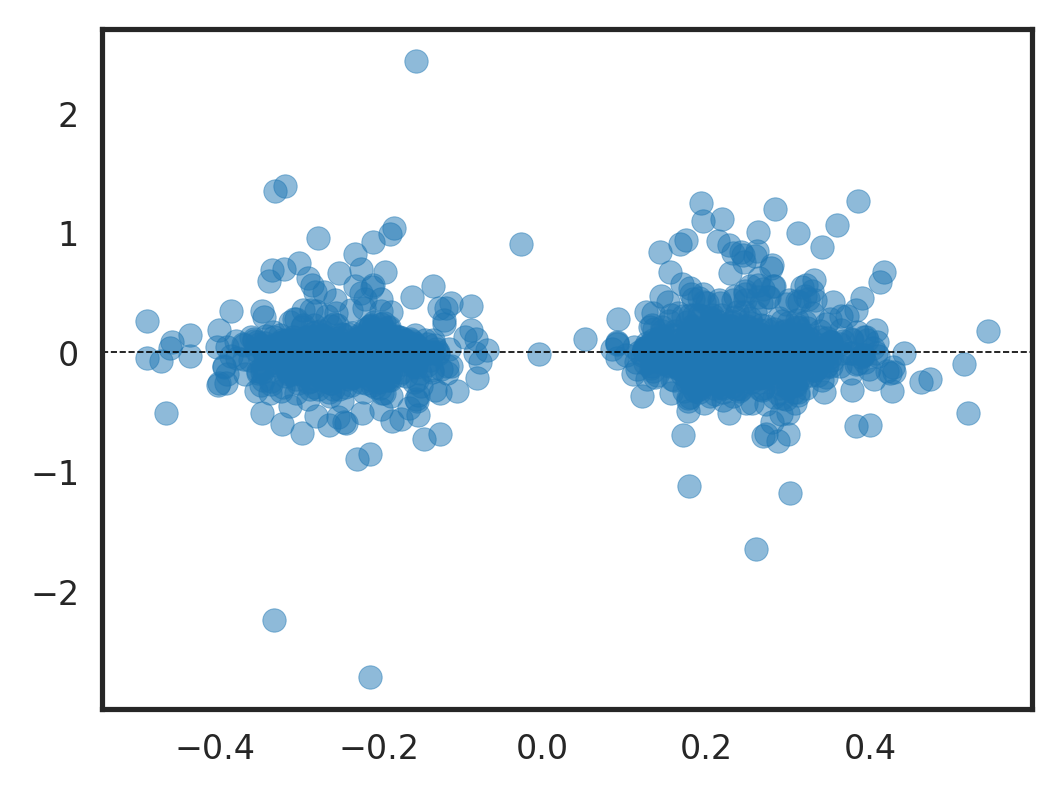

In [102]:

plt.figure(dpi=300,figsize=(4,3))
plt.scatter(mat3["EPZvsDMSO"],mat3["log2FoldChange"],alpha=0.5)
plt.axhline(0,linestyle='--',linewidth=0.4, color='k')